## Setting Up the Libs and Marmousi2 Configurations

In [1]:
##### from __future__ import print_function
import time
import torch
import torch.nn as nn
import numpy as np
import scipy.ndimage
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import deepwave
import os
from timeit import default_timer as timer
import scipy.io as spio
import math
import numpy as np
from utils.utils import *
from torch import optim
from IPython.core.debugger import set_trace 
import random
torch.manual_seed(0)
random.seed(0)

####################################################
####   MAIN PARAMETERS FOR FORWARD MODELING         ####
####################################################

peak_freq = 5.                    # central frequency
peak_source_time = 1 / peak_freq  # the time (in secs) of the peak amplitude
dx        = 30.0                  # step interval along x/z direction
dt        = 0.003                 # time interval (e.g., 3ms)
num_dims  = 2                     # dimension of velocity model
nz        = 117                   # model shape of z dimension (depth) Marmousi2
ny        = 567                   # model shape of y dimension Marmousi2
vmodel_dim = np.array([nz, ny])

total_t   = 6.                      # totle sampling time (unit: s)
nt        = int(total_t / dt)       # number of time sampling points
num_shots = 6                      # nunmber of shots
num_sources_per_shot = 5            # number of sources per 
num_shotsall = num_shots * num_sources_per_shot
num_receivers_per_shot = 567        # number of receivers per shot
source_spacing = np.floor(dx * ny / (num_shotsall+1))                         # space intervel between neigbouring sources
receiver_spacing = np.floor(dx * ny / (num_receivers_per_shot +1))         # space intervel between neigbouring receivers
source_depth = 0                # the index depth of sources, default is 0
receiver_depth = 0              # the index depths of receivers, default is 0
order          = 8              # precision order of finite difference in space domain
pml_width  = [0,10,10,10,0,0]   # pml padding width for boundary (0 for free surface and 10 for absorbing boundary)

#fwi_lr            = 20        # learning rate for updating the model.
fwi_lr = 50
fwi_batch         =   num_shots      # number of batches for FWI.
fwi_num_epochs    = 800       # number of FWI iteration.
#sim_lr            = 1*1e-5    # learning rate for Soamese network.
sim_lr = 1e-4
survey_pad = None
savepoch = 50                 # Saving models each 50 FWI iterations


/home/sadalyom/.conda/envs/FWIGAN/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##   Check Cuda Device 


In [2]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
device

device(type='cuda')

## Sorting the sources randomly


In [3]:

''' 
indx = []
for i in range (num_shots):
    indx.append(np.arange(i,num_shotsall,num_shots))
indx = (np.array(indx)).flatten()
'''
np.random.seed(42)
indx = np.random.permutation(num_shotsall)

indx

array([27, 15, 23, 17,  8,  9, 28, 24, 12,  0,  4, 16,  5, 13, 11, 22,  1,
        2, 25,  3, 21, 26, 18, 29, 20,  7, 10, 14, 19,  6])

In [4]:
 
data_path = 'data/mar_big_117_567.bin'
initfile = 'data/mar_big_initmodel.mat'
initsafile = 'data/mar_big_initsource.mat'
fwi_result = 'results/marmousimsfwi/'

# Loading the true model
model_true = loadtruemodel(data_path, num_dims, vmodel_dim).to(device)
# Smooth initial model
model, model_init = createInitialModel(model_true, 'GS', 10, 0, device)


# The model will be updated during FWI
model = torch.nn.Parameter(model)
# Creating source and reciver locations
_, x_r = createSR(num_shots, num_sources_per_shot, num_receivers_per_shot, num_dims, source_spacing, receiver_spacing,source_depth,receiver_depth)
x_s, _ = createSR(num_shotsall, 1, num_receivers_per_shot, num_dims, source_spacing, receiver_spacing,source_depth,receiver_depth)
x_s = x_s[indx]
x_s = x_s.reshape(num_shots, num_sources_per_shot,2)
x_s, x_r = x_s.to(device), x_r.to(device)
# Source Amplitude
source_amplitudes_init, source_amplitudes_true = loadinitsource(initsafile,device)
source = source_amplitudes_init.repeat(1,num_shots, num_sources_per_shot)
# receiver Amplitude
receiver_amplitudes = createdata(model_true,dx,source, \
                                x_s,x_r,dt,pml_width,order, \
                                 survey_pad,device).to(device)
receiver_amplitudes_true = receiver_amplitudes
rcv_amps_true = receiver_amplitudes_true.clone()

model size: torch.Size([117, 567])


## Plotting the inital and true model


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


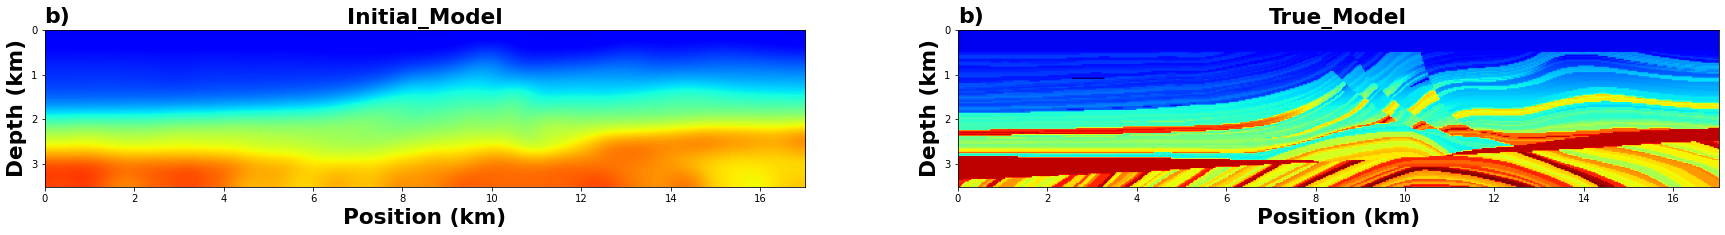

In [6]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

y = np.array([0, 1, 2, 3, 4])
box_min = 1140
box_max = 4700

f, ax = plt.subplots(1,2,figsize=(30, 13))
plt.rc('font', **font)


im = ax[0].imshow(model_init, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, model_init.shape[1] * dx / 1000, model_init.shape[0] * dx / 1000, 0])
ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'b)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

model1 = model_true.detach().cpu().numpy()
im = ax[1].imshow(model1, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, model1.shape[1] * dx / 1000, model1.shape[0] * dx / 1000, 0])
ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('True_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 


plt.show()

## Setting Up the Siamese and Optimizers

In [7]:
from torchsummary import summary
from Model.Module22_6 import *
import  torch


#Learning Schedule
def lr_lambda(epoch):
    return 1/2
#Learning Schedule
def lr_lambda1(epoch):
    return 1/2

### optimizer for the velocity model
optimizer = optim.Adam([{'params': model, 'lr':fwi_lr, 'betas':(0.5, 0.99), 'eps':1e-8,
                          'weight_decay':0}])

#Best
#leak_value = 0.0001
leak_value = 0.00001
D1 = 1
netD = SiameseNetwork(D1)
### init the hyper-parameters of netD ###
netD = netD.apply(lambda m: weights_init(m, leak_value))
netD = netD.to(device)


# Optimizer for Siamese network.
optim_s = optim.Adam(netD.parameters(),lr=sim_lr,betas=(0.5, 0.99), \
                    eps=1e-6, weight_decay=0)

scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda)
scheduler1 = torch.optim.lr_scheduler.MultiplicativeLR(optim_s, lr_lambda=lr_lambda1)

"""Compute number of parameters"""
s  = sum(np.prod(list(p.size())) for p in netD.parameters())
print ('Number of netD params: %d' % s)

summary(netD,[(3,nt,num_receivers_per_shot),(3,nt,num_receivers_per_shot)])


############## Init  ################# 
SNR = 0.0
SSIM = 0.0
Loss = 0.0
ERROR = 0.0




Number of netD params: 1519
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 3, 2000, 567]              84
         LeakyReLU-2         [-1, 3, 2000, 567]               0
            Conv2d-3         [-1, 3, 2000, 567]              84
         LeakyReLU-4         [-1, 3, 2000, 567]               0
            Conv2d-5         [-1, 3, 2000, 567]              84
         LeakyReLU-6         [-1, 3, 2000, 567]               0
            Conv2d-7         [-1, 4, 2000, 567]             112
         LeakyReLU-8         [-1, 4, 2000, 567]               0
            Conv2d-9         [-1, 4, 2000, 567]             112
        LeakyReLU-10         [-1, 4, 2000, 567]               0
           Conv2d-11         [-1, 3, 2000, 567]              84
        LeakyReLU-12         [-1, 3, 2000, 567]               0
           Conv2d-13         [-1, 3, 2000, 567]              84
        Lea

## Main SiameseFWI

In [9]:
import torch.fft
import torch.nn.functional as F
# Starting the FWI loop.
global model_true, source_amplitudes_init, SNR, SSIM, Loss, ERROR






t_start = time.time()
model_true = model_true.view(nz,ny)
# number of shots per batch
num_shots_per_batch = int(num_shots / fwi_batch) 
criterion = nn.MSELoss()
for i in range(fwi_num_epochs):
    # initialization of the loss
    epoch_loss = 0.0

    #batch_rcv_amps_true = torch.zeros((2000,1,567)).to(device)
    #batch_rcv_amps_pred = torch.zeros((2000,1,567)).to(device)
    for it in range(fwi_batch):
        iteration = i*fwi_batch+it+1
        #print(it,iteration)
        # Set both optimizers to zero grad.
        optimizer.zero_grad()
        netD.train()                
        netD.zero_grad() 
        
        # Forward modeling based on AWE (DeepWave).
        prop = deepwave.scalar.Propagator({'vp': model},dx,pml_width, \
                                          order,survey_pad)
        batch_src_amps = source_amplitudes_init.repeat(1, num_shots_per_batch, num_sources_per_shot)
        batch_rcv_amps_true= rcv_amps_true[:,it::fwi_batch].to(device)
        batch_x_s = x_s[it::fwi_batch].to(device)
        batch_x_r = x_r[it::fwi_batch].to(device)
        batch_rcv_amps_pred= prop(batch_src_amps, batch_x_s, batch_x_r, dt)
        
        # A, R, and I
        d_real = batch_rcv_amps_true[:,0,:]
        d_real_f = torch.fft.fft(d_real, dim=0)
        d_abs = torch.abs(d_real_f)
        d_abs = torch.cat([d_abs[0:400,:],d_abs[-400:,:]])
        #d_abs = d_abs.permute(1,0)
        d_abs = d_abs.unsqueeze(0).unsqueeze(0)
        
        d_real_r = torch.real(d_real_f)
        d_real_r = torch.cat([d_real_r[0:400,:],d_real_r[-400:,:]])
        #d_real_r = d_real_r.permute(1,0)
        d_real_r = d_real_r.unsqueeze(0).unsqueeze(0)
        
        d_real_i = torch.imag(d_real_f)
        d_real_i = torch.cat([d_real_i[0:400,:],d_real_i[-400:,:]])
        #d_real_i = d_real_i.permute(1,0)
        d_real_i = d_real_i.unsqueeze(0).unsqueeze(0)
        d_real_inp = torch.cat([d_real_r,d_real_i,d_abs],axis=1)



        d_fake = batch_rcv_amps_pred[:,0,:]       
        d_fake_f = torch.fft.fft(d_fake, dim=0)
        d_abs_f = torch.abs(d_fake_f)
        d_abs_f = torch.cat([d_abs_f[0:400,:],d_abs_f[-400:,:]])
        #d_abs_f = d_abs_f.permute(1,0)
        d_abs_f = d_abs_f.unsqueeze(0).unsqueeze(0)
        
        
        d_fake_r = (torch.real(d_fake_f))
        d_fake_r = torch.cat([d_fake_r[0:400,:],d_fake_r[-400:,:]])
        #d_fake_r = d_fake_r.permute(1,0)
        d_fake_r = d_fake_r.unsqueeze(0).unsqueeze(0)

        d_fake_i = (torch.imag(d_fake_f))
        d_fake_i = torch.cat([d_fake_i[0:400,:],d_fake_i[-400:,:]])
        #d_fake_i = d_fake_i.permute(1,0)
        d_fake_i = d_fake_i.unsqueeze(0).unsqueeze(0)
        d_fake_inp = torch.cat([d_fake_r,d_fake_i,d_abs_f],axis=1)
        
        disc_fake, disc_real, o1, o2 = netD(d_real_inp,d_fake_inp)
        loss = 0.2*F.pairwise_distance(o1[0,0,:,:],o2[0,0,:,:], keepdim = True).mean() + 0.2*F.pairwise_distance(o1[0,1,:,:],o2[0,1,:,:], keepdim = True).mean()+ 0.6*F.pairwise_distance(o1[0,2,:,:],o2[0,2,:,:], keepdim = True).mean()



        epoch_loss += loss.item()
        loss.backward()
        # Updating the Siamese network.
        optim_s.step()

        # Clips gradient value of model
        torch.nn.utils.clip_grad_value_(model,1e3) 
        # Update the velocity model
        optimizer.step()
        # clip the model value that keep the minimum value is larger than 0
        model.data=torch.clamp(model.data,min=1e-12)


    # Update the learning rate each 100 FWI iterations .
    if (i>0) and (i%70==0):
    #if (epoch_loss / fwi_batch)>lossglob:
    ###    countv=0
    
        scheduler.step()
        scheduler1.step()
    after_lr = optim_s.param_groups[0]["lr"]
    
    Loss = np.append(Loss, epoch_loss / fwi_batch)

    # compute the SNR and SSIM
    snr = ComputeSNR(model.detach().cpu().numpy(),  
              model_true.detach().cpu().numpy())
    SNR = np.append(SNR, snr)

    ssim = ComputeSSIM(model.detach().cpu().numpy(), \
              model_true.detach().cpu().numpy())
    SSIM = np.append(SSIM, ssim)

    
    rerror = ComputeRE(model.detach().cpu().numpy(), \
              model_true.detach().cpu().numpy())
    ERROR = np.append(ERROR, rerror)

    print('Epoch:', i+1, 'Loss: ', epoch_loss / fwi_batch, 'lr:' , str(after_lr), 'SNR:', snr, 'SSIM:', ssim.cpu().detach().cpu().numpy())
    if (i+1) % savepoch == 0 or (i+1) == fwi_num_epochs:
    # Save the model and the metrics.
        spio.savemat(fwi_result+'SIAMESERec_.mat', \
                         {'rec':model.cpu().data.numpy()}) 
        spio.savemat(fwi_result+'SIAMESEMetric_.mat', \
                         {'SNR':SNR,'SSIM':SSIM, \
                          'Loss':Loss,'ERROR':ERROR}) 

# Estimating the FWI time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))
# Save the final metrics.
np.savetxt(fwi_result+'run_result.txt', np.hstack((fwi_num_epochs,elapsed_time//60,elapsed_time % 60,snr,ssim,rerror)), fmt='%5.4f') 



Epoch: 1 Loss:  1332.4268798828125 lr: 0.0001 SNR: 16.658669221868653 SSIM: 0.11983618
Epoch: 2 Loss:  1237.9762573242188 lr: 0.0001 SNR: 16.445263526841963 SSIM: 0.12667875
Epoch: 3 Loss:  1187.7886352539062 lr: 0.0001 SNR: 16.224179909125954 SSIM: 0.12504925
Epoch: 4 Loss:  1202.060791015625 lr: 0.0001 SNR: 16.160154041988775 SSIM: 0.12907338
Epoch: 5 Loss:  1185.5467325846355 lr: 0.0001 SNR: 16.030614088400778 SSIM: 0.12624894
Epoch: 6 Loss:  1183.7428588867188 lr: 0.0001 SNR: 15.94604761106856 SSIM: 0.13326544
Epoch: 7 Loss:  1186.9022013346355 lr: 0.0001 SNR: 15.911802722197272 SSIM: 0.13621014
Epoch: 8 Loss:  1160.2251383463542 lr: 0.0001 SNR: 15.888579978479267 SSIM: 0.14059608
Epoch: 9 Loss:  1120.6776936848958 lr: 0.0001 SNR: 15.84489188880202 SSIM: 0.13930568
Epoch: 10 Loss:  1154.0244954427083 lr: 0.0001 SNR: 15.817485316714171 SSIM: 0.14066781
Epoch: 11 Loss:  1152.5111287434895 lr: 0.0001 SNR: 15.802542001087156 SSIM: 0.1455669
Epoch: 12 Loss:  1138.9866943359375 lr: 0.000

Epoch: 97 Loss:  509.42189534505206 lr: 5e-05 SNR: 16.675191696780725 SSIM: 0.33377692
Epoch: 98 Loss:  503.96397399902344 lr: 5e-05 SNR: 16.66116962398075 SSIM: 0.33487785
Epoch: 99 Loss:  460.4453887939453 lr: 5e-05 SNR: 16.71336575062108 SSIM: 0.33821702
Epoch: 100 Loss:  456.0215250651042 lr: 5e-05 SNR: 16.75275699308663 SSIM: 0.34028348
Epoch: 101 Loss:  458.8268686930339 lr: 5e-05 SNR: 16.766567755944088 SSIM: 0.34444234
Epoch: 102 Loss:  459.43230692545575 lr: 5e-05 SNR: 16.828483800527167 SSIM: 0.34559968
Epoch: 103 Loss:  491.754145304362 lr: 5e-05 SNR: 16.805234579159848 SSIM: 0.34611443
Epoch: 104 Loss:  470.731938680013 lr: 5e-05 SNR: 16.855506460670277 SSIM: 0.34586728
Epoch: 105 Loss:  448.9882456461589 lr: 5e-05 SNR: 16.86187896740344 SSIM: 0.34878632
Epoch: 106 Loss:  446.65321858723956 lr: 5e-05 SNR: 16.90562421109091 SSIM: 0.35007274
Epoch: 107 Loss:  441.7272135416667 lr: 5e-05 SNR: 16.935819196277517 SSIM: 0.35255232
Epoch: 108 Loss:  434.37347412109375 lr: 5e-05 SN

Epoch: 191 Loss:  207.95030721028647 lr: 2.5e-05 SNR: 18.14444174095568 SSIM: 0.49085185
Epoch: 192 Loss:  240.71950022379556 lr: 2.5e-05 SNR: 18.161221277651414 SSIM: 0.49274737
Epoch: 193 Loss:  236.5792032877604 lr: 2.5e-05 SNR: 18.163263587751384 SSIM: 0.49237302
Epoch: 194 Loss:  233.32313537597656 lr: 2.5e-05 SNR: 18.172349136296383 SSIM: 0.49378958
Epoch: 195 Loss:  221.8927205403646 lr: 2.5e-05 SNR: 18.178264435910215 SSIM: 0.4943127
Epoch: 196 Loss:  222.70596822102866 lr: 2.5e-05 SNR: 18.190625681528832 SSIM: 0.49580222
Epoch: 197 Loss:  214.90794626871744 lr: 2.5e-05 SNR: 18.20617162222429 SSIM: 0.49730575
Epoch: 198 Loss:  205.99854787190756 lr: 2.5e-05 SNR: 18.217866928431434 SSIM: 0.49896955
Epoch: 199 Loss:  202.30545298258463 lr: 2.5e-05 SNR: 18.224912159106115 SSIM: 0.50107265
Epoch: 200 Loss:  203.4777043660482 lr: 2.5e-05 SNR: 18.23893722028524 SSIM: 0.5023916
Epoch: 201 Loss:  227.1349843343099 lr: 2.5e-05 SNR: 18.250834813611526 SSIM: 0.5036296
Epoch: 202 Loss:  20

Epoch: 283 Loss:  52.844544092814125 lr: 6.25e-06 SNR: 18.791658234254875 SSIM: 0.592533
Epoch: 284 Loss:  52.80911445617676 lr: 6.25e-06 SNR: 18.794505647192246 SSIM: 0.59341764
Epoch: 285 Loss:  53.416297912597656 lr: 6.25e-06 SNR: 18.794370266932567 SSIM: 0.5938792
Epoch: 286 Loss:  55.61380259195963 lr: 6.25e-06 SNR: 18.796201411153113 SSIM: 0.5946901
Epoch: 287 Loss:  63.73721694946289 lr: 6.25e-06 SNR: 18.79994895765904 SSIM: 0.59515953
Epoch: 288 Loss:  57.252638498942055 lr: 6.25e-06 SNR: 18.802464305598654 SSIM: 0.59588337
Epoch: 289 Loss:  61.65776824951172 lr: 6.25e-06 SNR: 18.80405512219703 SSIM: 0.5963665
Epoch: 290 Loss:  63.88138198852539 lr: 6.25e-06 SNR: 18.80832003405431 SSIM: 0.5969104
Epoch: 291 Loss:  63.80297660827637 lr: 6.25e-06 SNR: 18.80899932264455 SSIM: 0.5973758
Epoch: 292 Loss:  60.18959045410156 lr: 6.25e-06 SNR: 18.813875936408923 SSIM: 0.5980124
Epoch: 293 Loss:  58.8738047281901 lr: 6.25e-06 SNR: 18.81635706389168 SSIM: 0.59844595
Epoch: 294 Loss:  60.

Epoch: 375 Loss:  34.78455797831217 lr: 3.125e-06 SNR: 19.000145283293108 SSIM: 0.6307276
Epoch: 376 Loss:  33.644575436909996 lr: 3.125e-06 SNR: 19.00178814591349 SSIM: 0.6310834
Epoch: 377 Loss:  34.72553793589274 lr: 3.125e-06 SNR: 19.002778019589567 SSIM: 0.63123274
Epoch: 378 Loss:  33.65217208862305 lr: 3.125e-06 SNR: 19.00460937499762 SSIM: 0.63156265
Epoch: 379 Loss:  33.641374588012695 lr: 3.125e-06 SNR: 19.00517733145754 SSIM: 0.6317432
Epoch: 380 Loss:  32.18037064870199 lr: 3.125e-06 SNR: 19.00718137210022 SSIM: 0.63211346
Epoch: 381 Loss:  31.476170857747395 lr: 3.125e-06 SNR: 19.007556519773086 SSIM: 0.632246
Epoch: 382 Loss:  30.54567750295003 lr: 3.125e-06 SNR: 19.009782716797268 SSIM: 0.6326496
Epoch: 383 Loss:  29.530214309692383 lr: 3.125e-06 SNR: 19.009589481994524 SSIM: 0.63280046
Epoch: 384 Loss:  32.307257970174156 lr: 3.125e-06 SNR: 19.01288490608881 SSIM: 0.6331368
Epoch: 385 Loss:  32.69398816426595 lr: 3.125e-06 SNR: 19.012126987158073 SSIM: 0.63334405
Epoch:

Epoch: 466 Loss:  23.29258632659912 lr: 1.5625e-06 SNR: 19.0926996477871 SSIM: 0.6483208
Epoch: 467 Loss:  22.603657086690266 lr: 1.5625e-06 SNR: 19.093396512114893 SSIM: 0.6484708
Epoch: 468 Loss:  22.279525756835938 lr: 1.5625e-06 SNR: 19.09414619881107 SSIM: 0.64859897
Epoch: 469 Loss:  21.663798332214355 lr: 1.5625e-06 SNR: 19.09494318168385 SSIM: 0.64876026
Epoch: 470 Loss:  21.40738646189372 lr: 1.5625e-06 SNR: 19.09557278192653 SSIM: 0.6488956
Epoch: 471 Loss:  20.998149236043293 lr: 1.5625e-06 SNR: 19.09655696142148 SSIM: 0.64906734
Epoch: 472 Loss:  20.865087668100994 lr: 1.5625e-06 SNR: 19.096974778744663 SSIM: 0.6491963
Epoch: 473 Loss:  21.67750835418701 lr: 1.5625e-06 SNR: 19.098351229392186 SSIM: 0.64934385
Epoch: 474 Loss:  22.047697067260742 lr: 1.5625e-06 SNR: 19.09853151505983 SSIM: 0.64948386
Epoch: 475 Loss:  22.78753089904785 lr: 1.5625e-06 SNR: 19.099860179657707 SSIM: 0.64963055
Epoch: 476 Loss:  22.362278938293457 lr: 1.5625e-06 SNR: 19.100353817130234 SSIM: 0.6

Epoch: 556 Loss:  17.10381778081258 lr: 7.8125e-07 SNR: 19.146685841374854 SSIM: 0.65783876
Epoch: 557 Loss:  16.956393559773762 lr: 7.8125e-07 SNR: 19.147356183995804 SSIM: 0.65795773
Epoch: 558 Loss:  16.865524450937908 lr: 7.8125e-07 SNR: 19.147700876564876 SSIM: 0.658018
Epoch: 559 Loss:  17.11942481994629 lr: 7.8125e-07 SNR: 19.148469977516832 SSIM: 0.6581301
Epoch: 560 Loss:  17.233572006225586 lr: 7.8125e-07 SNR: 19.148753127289417 SSIM: 0.6582213
Epoch: 561 Loss:  17.852601051330566 lr: 3.90625e-07 SNR: 19.149562146966176 SSIM: 0.65829146
Epoch: 562 Loss:  17.133902231852215 lr: 3.90625e-07 SNR: 19.149693684553267 SSIM: 0.65834904
Epoch: 563 Loss:  16.14552942911784 lr: 3.90625e-07 SNR: 19.15002476544122 SSIM: 0.65839535
Epoch: 564 Loss:  16.056340376536053 lr: 3.90625e-07 SNR: 19.15030353300182 SSIM: 0.6584372
Epoch: 565 Loss:  16.004839579264324 lr: 3.90625e-07 SNR: 19.150590153893173 SSIM: 0.6585147
Epoch: 566 Loss:  15.989892641703287 lr: 3.90625e-07 SNR: 19.150886190572894

Epoch: 645 Loss:  15.08376375834147 lr: 1.953125e-07 SNR: 19.177023835647404 SSIM: 0.66311467
Epoch: 646 Loss:  15.079180240631104 lr: 1.953125e-07 SNR: 19.17722492518416 SSIM: 0.6631607
Epoch: 647 Loss:  15.074666817982992 lr: 1.953125e-07 SNR: 19.17742733564196 SSIM: 0.6631875
Epoch: 648 Loss:  15.07003927230835 lr: 1.953125e-07 SNR: 19.17763109184565 SSIM: 0.6632267
Epoch: 649 Loss:  15.06508763631185 lr: 1.953125e-07 SNR: 19.177836084592304 SSIM: 0.6632644
Epoch: 650 Loss:  15.060121854146322 lr: 1.953125e-07 SNR: 19.178042316391387 SSIM: 0.66330653
Epoch: 651 Loss:  15.0548947652181 lr: 1.953125e-07 SNR: 19.178249481908324 SSIM: 0.66335046
Epoch: 652 Loss:  15.049702962239584 lr: 1.953125e-07 SNR: 19.178457736616664 SSIM: 0.6633811
Epoch: 653 Loss:  15.044778982798258 lr: 1.953125e-07 SNR: 19.17866697361504 SSIM: 0.66342497
Epoch: 654 Loss:  15.039634863535563 lr: 1.953125e-07 SNR: 19.178877353353744 SSIM: 0.6634783
Epoch: 655 Loss:  15.034385522206625 lr: 1.953125e-07 SNR: 19.179

Epoch: 733 Loss:  14.554364681243896 lr: 9.765625e-08 SNR: 19.192810631435005 SSIM: 0.6662158
Epoch: 734 Loss:  14.550747394561768 lr: 9.765625e-08 SNR: 19.19292563831766 SSIM: 0.66623986
Epoch: 735 Loss:  14.547203540802002 lr: 9.765625e-08 SNR: 19.193040697097146 SSIM: 0.6662701
Epoch: 736 Loss:  14.54391860961914 lr: 9.765625e-08 SNR: 19.193155820801927 SSIM: 0.666301
Epoch: 737 Loss:  14.5406707127889 lr: 9.765625e-08 SNR: 19.193271012074092 SSIM: 0.6663364
Epoch: 738 Loss:  14.537380536397299 lr: 9.765625e-08 SNR: 19.193386255522835 SSIM: 0.66635007
Epoch: 739 Loss:  14.533891518910727 lr: 9.765625e-08 SNR: 19.193501506753012 SSIM: 0.6663753
Epoch: 740 Loss:  14.530632336934408 lr: 9.765625e-08 SNR: 19.193616824731837 SSIM: 0.6663953
Epoch: 741 Loss:  14.527007261912027 lr: 9.765625e-08 SNR: 19.193732182618582 SSIM: 0.66641396
Epoch: 742 Loss:  14.523814837137857 lr: 9.765625e-08 SNR: 19.193847607898963 SSIM: 0.66643965
Epoch: 743 Loss:  14.520266691843668 lr: 9.765625e-08 SNR: 19

## Example of the super-shot

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


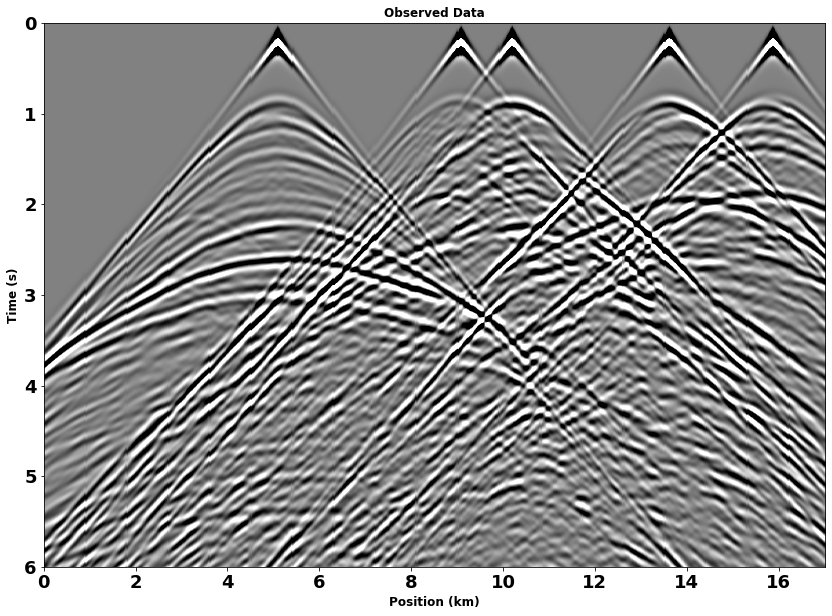

In [10]:
#plt.imshow(batch_rcv_amps_true[:,0,:].detach().cpu().numpy(),aspect='auto',cmap='gray')
#batch_rcv_amps_true[:,0,:].shape


%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}
f, ax = plt.subplots(1, 1, figsize=(14, 10), sharey=False)
plt.rc('font', **font)

selected_shot = rcv_amps_true[:,0,:]
vmin, vmax = torch.quantile(selected_shot,
                            torch.tensor([0.05, 0.95]).to(device))

ax.imshow(selected_shot.cpu(), aspect='auto', cmap='gray',
             vmin=vmin, vmax=vmax,
             extent=[0, selected_shot.shape[1] * dx/1000, selected_shot.shape[0] *(0.003), 0])

ax.set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax.set_ylabel('Time (s)',fontsize='large', fontweight='bold')
ax.set_title('Observed Data',fontsize='large', fontweight='bold')
#ax.text(0, -0.15, 'a)', fontsize = 12) 
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.set_xticklabels([])
plt.show()
#f.savefig('Observed_Combined.png', bbox_inches='tight',transparent=True, dpi =100)


## Plotting the Reconstructed Velocity Model

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


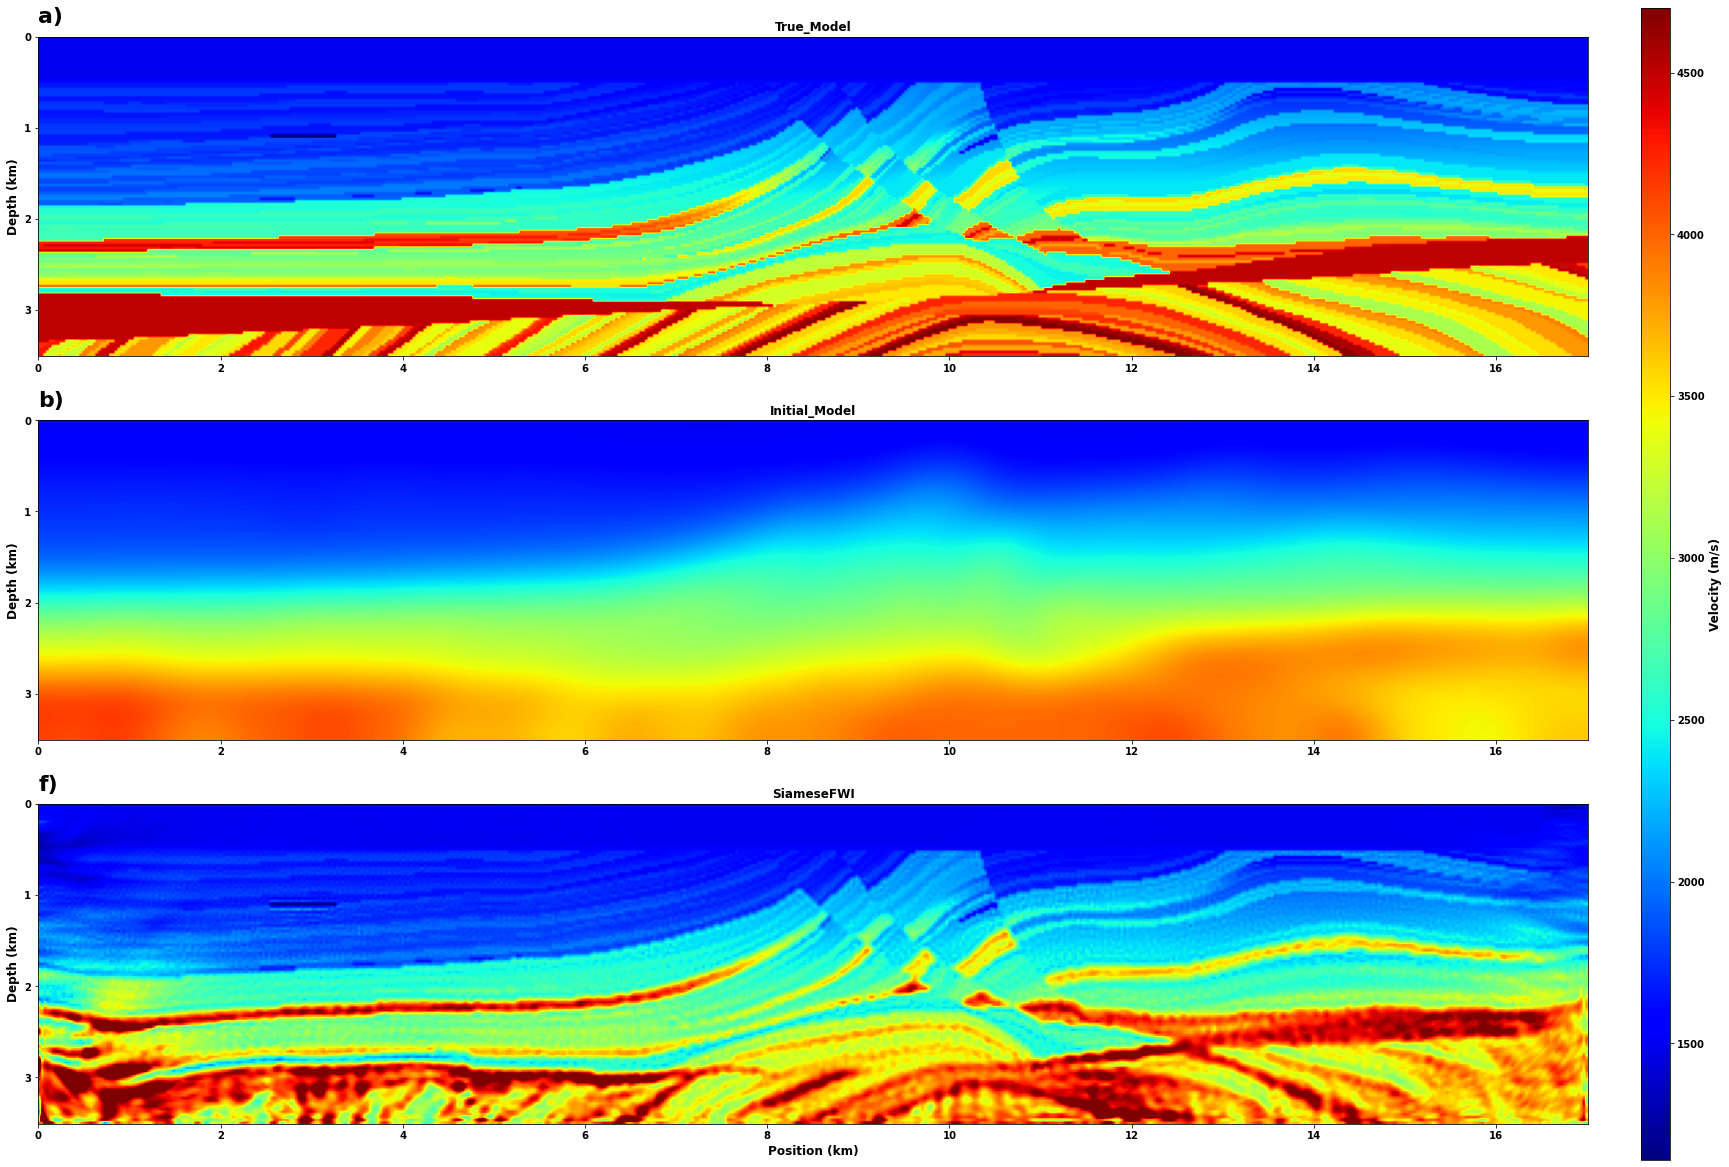

The reconstructed velocity model has SNR: 19.198865296134166 dB and SSIM: 0.66752875


In [13]:
f, ax = plt.subplots(3,1,figsize=(40, 20))
plt.rc('font', **font)

# True Model
modeltrue = model1
im = ax[0].imshow(modeltrue, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, modeltrue.shape[1] * dx / 1000, modeltrue.shape[0] * dx / 1000, 0])

#ax[0].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_title('True_Model',fontsize='large', fontweight='bold')
ax[0].text(0, -0.15, 'a)', fontsize = 22) 
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Initial Model
init_V = model_init
im = ax[1].imshow(init_V, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, init_V.shape[1] * dx / 1000, init_V.shape[0] * dx / 1000, 0])
#ax[1].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[1].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[1].set_title('Initial_Model',fontsize='large', fontweight='bold')
ax[1].text(0, -0.15, 'b)', fontsize = 22) 
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_yticks(np.arange(y.min(), y.max(), 1)) 

# Siamese Model
Siamese_Vel = scipy.io.loadmat(fwi_result + 'SIAMESERec_.mat')
Siamese_Vel = Siamese_Vel['rec']
im = ax[2].imshow(Siamese_Vel, cmap='jet', vmin=box_min, vmax=box_max, 
                extent=[0, Siamese_Vel.shape[1] * dx / 1000, Siamese_Vel.shape[0] * dx / 1000, 0])
ax[2].set_xlabel('Position (km)',fontsize='large', fontweight='bold')
ax[2].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[2].set_title('SiameseFWI',fontsize='large', fontweight='bold')
ax[2].text(0, -0.15, 'f)', fontsize = 22) 
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].set_yticks(np.arange(y.min(), y.max(), 1)) 


cbar_ax = f.add_axes([0.8, 0.1, 0.01, 0.8])
f.colorbar(im, fraction=0.005, pad=0.04,cax=cbar_ax)
cbar_ax.set_ylabel('Velocity (m/s)',fontsize='large', fontweight='bold')

plt.show()
f.savefig('FreqFWI_Siamese.png', bbox_inches='tight',transparent=True, dpi =100)

snr = ComputeSNR(Siamese_Vel,  
          model_true.detach().cpu().numpy())

ssim = ComputeSSIM(Siamese_Vel, \
          model_true.detach().cpu().numpy())

print('The reconstructed velocity model has SNR:', str(snr), 'dB', 'and SSIM:',str(ssim.cpu().detach().cpu().numpy()))

## Plotting Velocities Profiles

@Position =  3.6 km, RMSE =  0.22373308823782465 km/s
@Position =  7.2 km, RMSE =  0.18403971056567603 km/s
@Position =  14.4 km, RMSE =  0.1847415412384666 km/s


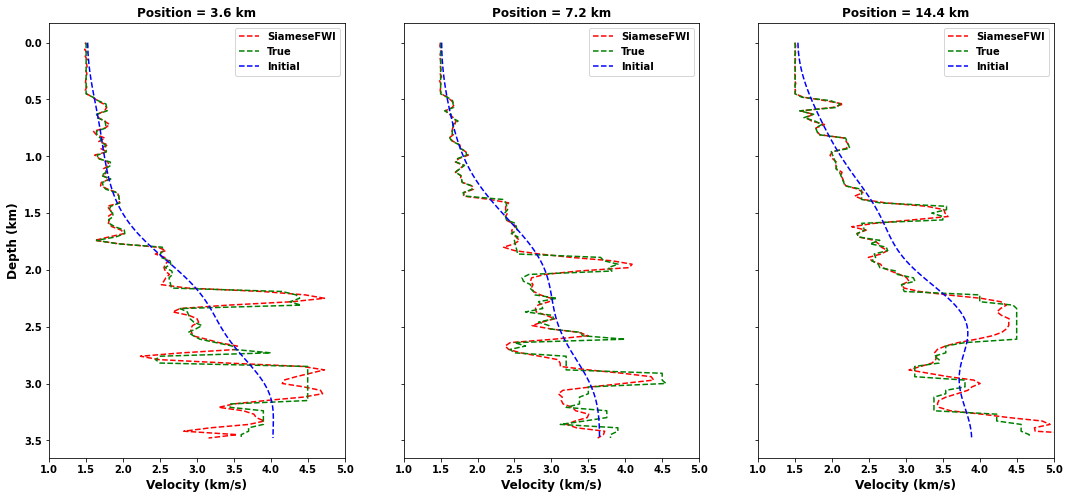

In [14]:
from math import sqrt
# position 1
k = 120

xy = np.arange(0,Siamese_Vel.shape[0] * dx / 1000, len(Siamese_Vel[:,k])/Siamese_Vel.shape[0] * dx / 1000)
f, ax = plt.subplots(figsize=(18, 8), ncols=3,nrows=1)
xx = np.arange(0,4)
ax[0].plot(Siamese_Vel[:,k]/1000,xy,'r--',label='SiameseFWI')
ax[0].plot(modeltrue[:,k]/1000,xy,'g--',label='True')
ax[0].plot(init_V[:,k]/1000,xy,'b--',label='Initial')
ax[0].set_ylabel('Depth (km)',fontsize='large', fontweight='bold')
ax[0].set_xlabel('Velocity (km/s)',fontsize='large', fontweight='bold')
ax[0].set_xlim([1,5])
ax[0].legend(loc='upper right')
ax[0].set_title( 'Position = ' + str(k * dx / 1000) +' km',fontsize='large', fontweight='bold')
ax[0].invert_yaxis()
rms = sqrt(np.mean(((modeltrue[:,k]-Siamese_Vel[:,k])/1000)**2))
print('@Position = ', str(k * dx / 1000), 'km, RMSE = ',str(rms), 'km/s')

# position 2
k = 240
xy = np.arange(0,Siamese_Vel.shape[0] * dx / 1000, len(Siamese_Vel[:,k])/Siamese_Vel.shape[0] * dx / 1000)
xx = np.arange(0,4)
ax[1].plot(Siamese_Vel[:,k]/1000,xy,'r--',label='SiameseFWI')
ax[1].plot(modeltrue[:,k]/1000,xy,'g--',label='True')
ax[1].plot(init_V[:,k]/1000,xy,'b--',label='Initial')
ax[1].set_xlabel('Velocity (km/s)',fontsize='large', fontweight='bold')
ax[1].set_yticklabels([])
ax[1].set_xlim([1,5])
ax[1].legend(loc='upper right')
ax[1].set_title( 'Position = ' + str(k * dx / 1000) +' km',fontsize='large', fontweight='bold')
ax[1].invert_yaxis()
rms = sqrt(np.mean(((modeltrue[:,k]-Siamese_Vel[:,k])/1000)**2))
print('@Position = ', str(k * dx / 1000), 'km, RMSE = ',str(rms), 'km/s')

# position 3
k = 480
xy = np.arange(0,Siamese_Vel.shape[0] * dx / 1000, len(Siamese_Vel[:,k])/Siamese_Vel.shape[0] * dx / 1000)
xx = np.arange(0,4)
ax[2].plot(Siamese_Vel[:,k]/1000,xy,'r--',label='SiameseFWI')
ax[2].plot(modeltrue[:,k]/1000,xy,'g--',label='True')
#ax[2].plot(FWIGAN_Vel[:,k]/1000,xy,'y--',label='FWIGAN')
ax[2].plot(init_V[:,k]/1000,xy,'b--',label='Initial')
ax[2].set_xlabel('Velocity (km/s)',fontsize='large', fontweight='bold')
ax[2].set_yticklabels([])
ax[2].set_xlim([1,5])
#ax[2].ylim([0,3.8])
ax[2].legend(loc='upper right')
ax[2].set_title( 'Position = ' + str(k * dx / 1000) +' km',fontsize='large', fontweight='bold')
ax[2].invert_yaxis()
rms = sqrt(np.mean(((modeltrue[:,k]-Siamese_Vel[:,k])/1000)**2))
print('@Position = ', str(k * dx / 1000), 'km, RMSE = ',str(rms), 'km/s')

